In [2]:
import glob
from functools import reduce
import cartopy.crs as ccrs
import cartopy.feature as cf
import cftime as cf
import geopandas as gp
import matplotlib as mpl
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import regionmask
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from IPython.display import Markdown
from matplotlib import colors
import geopandas as gpd
import warnings

In [2]:
# Prepare for units transformation from mm/year to m3/year
mm_to_m = 10**(-3)
mm_per_s_to_mm_per_day = 86400.0

lnd_area_ctsm_f09_g17 =  xr.open_dataset('/glade/scratch/staranu/archive/ctsm_escomp_irrig_rof_limited/lnd/hist/selected_data/area/area_lnd.nc', decode_times=False)['area'].values.flatten()*(10**6) # transform from km2 to m2
mask_lnd_ctsm_f09_g17 = xr.open_dataset('/glade/u/home/staranu/useful_data/landmask.nc', decode_times=False)['landmask'].values.flatten()
ctsm_f09_g17_mm_per_year_to_km3_per_year_transform = mm_per_s_to_mm_per_day*mm_to_m*lnd_area_ctsm_f09_g17/(10**9)

lon_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LONGXY'].values[0]
lat_ctsm_f09_g17 = xr.open_dataset('/glade/work/staranu/sectorWater_tools/tools/mksurfdata_map/surfdata_for_each_year/1971/surfdata_0.9x1.25_hist_78pfts_CMIP6_simyr1971_c230217.nc')['LATIXY'].values[:,0]

In [3]:
# Read the output data for the simulation with sector water usage on
path_simulation_data_with_sector_water_abstractions = "/glade/work/staranu/paper1_data_simulations/paper1_sectorwater_run.clm2.h1.1971-2010.nc"
output_data_sectorwater_simulation = xr.open_dataset(path_simulation_data_with_sector_water_abstractions, decode_times=False)

In [5]:
warnings.filterwarnings('ignore')
import xarray as xr

# List of variables to extract
expected_vars = ["DOM_EXPECTED_WITHD", "LIV_EXPECTED_WITHD", "ELEC_EXPECTED_WITHD", "MFC_EXPECTED_WITHD", "MIN_EXPECTED_WITHD", "QIRRIG_DEMAND"]
actual_vars = ["DOM_ACTUAL_WITHD", "LIV_ACTUAL_WITHD", "ELEC_ACTUAL_WITHD", "MFC_ACTUAL_WITHD", "MIN_ACTUAL_WITHD",  "QIRRIG_FROM_SURFACE"]

# Define the start year of the analysis
first_analysis_year = 1973

# Initialize the time counters
init_time = 365 * 2  # Skip first two years (1971 and 1972)
step = 365

# Initialize empty data array for unsatisfied days
unsatisfied_days = output_data_sectorwater_simulation.DOM_ACTUAL_WITHD[0,:,:].copy(deep=True)*0.0
unsatisfied_days = xr.DataArray(unsatisfied_days.values, dims=unsatisfied_days.dims, name="UNSATISFIED_DAYS")

for year in range(first_analysis_year, 2011):

    # Set the end time for the current year
    end_time = init_time + step

    for day in range(init_time, end_time):
        daily_total_expected_withd = (sum(output_data_sectorwater_simulation[exp_var][day, :, :] for exp_var in expected_vars) * ctsm_f09_g17_mm_per_year_to_km3_per_year_transform.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])))
        daily_total_actual_withd = (sum(output_data_sectorwater_simulation[act_var][day, :, :] for act_var in actual_vars) * ctsm_f09_g17_mm_per_year_to_km3_per_year_transform.reshape((lat_ctsm_f09_g17.shape[0], lon_ctsm_f09_g17.shape[0])))

        unsatisfied_days += (daily_total_expected_withd > daily_total_actual_withd)

    # Update the initial time for the next year
    init_time = end_time

    print("Year completed: " + str(year))

# Compute the average unsatisfied days over the years
mean_unsatisfied_days = unsatisfied_days / (2011 - first_analysis_year)

Year completed: 1973
Year completed: 1974
Year completed: 1975
Year completed: 1976
Year completed: 1977
Year completed: 1978
Year completed: 1979
Year completed: 1980
Year completed: 1981
Year completed: 1982
Year completed: 1983
Year completed: 1984
Year completed: 1985
Year completed: 1986
Year completed: 1987
Year completed: 1988
Year completed: 1989
Year completed: 1990
Year completed: 1991
Year completed: 1992
Year completed: 1993
Year completed: 1994
Year completed: 1995
Year completed: 1996
Year completed: 1997
Year completed: 1998
Year completed: 1999
Year completed: 2000
Year completed: 2001
Year completed: 2002
Year completed: 2003
Year completed: 2004
Year completed: 2005
Year completed: 2006
Year completed: 2007
Year completed: 2008
Year completed: 2009
Year completed: 2010


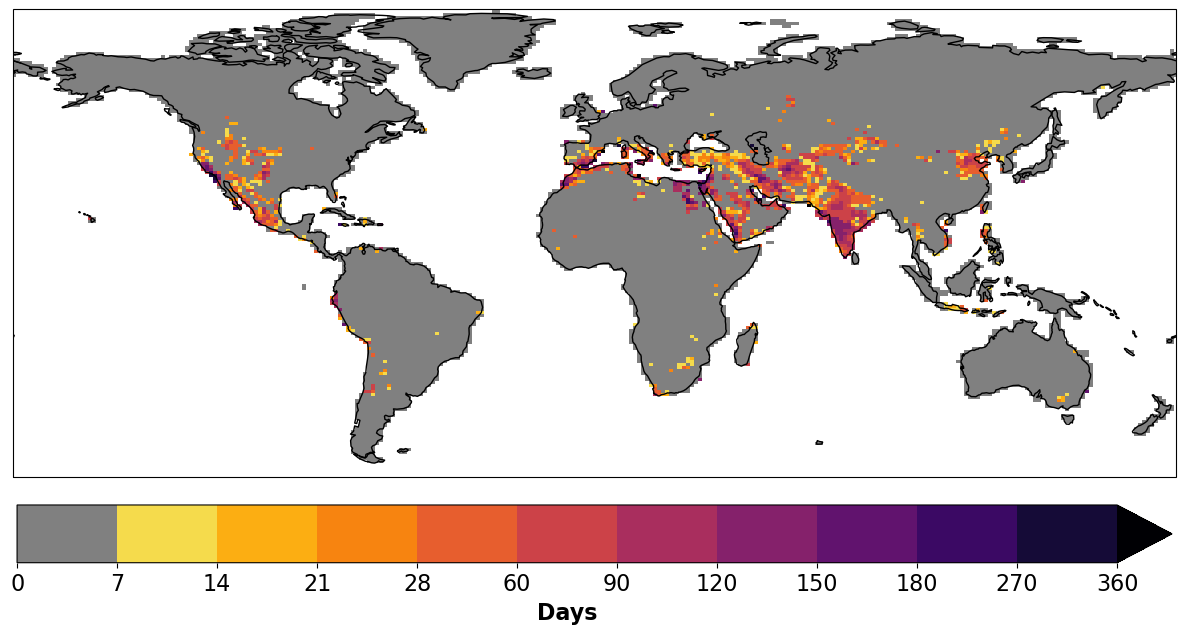

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import warnings
import matplotlib as mpl
import regionmask
import matplotlib.colors as mcolors
import cartopy.feature as cfeature

extent = [-180, 180, -60, 85]

# First, get the global map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Drop Antarctica and Greenland
world = world[(world.name != "Antarctica") & (world.name != "Greenland")]

# Define your data's Coordinate Reference System (CRS)
crs = ccrs.PlateCarree()

# First, get the global map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a global mask with Antarctica and Greenland included
global_mask = regionmask.mask_geopandas(world, lon_ctsm_f09_g17, lat_ctsm_f09_g17)

# Get the region numbers for Antarctica and Greenland
antarc_number = world[world.name == "Antarctica"].index[0]
greenland_number = world[world.name == "Greenland"].index[0]

# Color map
cmap = plt.cm.inferno_r
# cmap = plt.cm.afmhot_r
# Create a list of colors from the colormap
colors = cmap(np.arange(cmap.N))

# Change the first color to gray
colors[0] = np.array([0.5, 0.5, 0.5, 1.0])

# Create a new colormap
new_cmap = mcolors.LinearSegmentedColormap.from_list('gray_inferno', colors)

bounds = [0, 7, 14, 21, 28, 60, 90, 120, 150, 180, 270, 360]
ticks = bounds
norm = mpl.colors.BoundaryNorm(bounds, new_cmap.N, extend='max')

# Define time and zero line
zero_line = np.zeros(38)
years = np.linspace(1973, 2010, 38)

# Create a Cartopy projection and map
fig = plt.figure(figsize=(15, 15))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_global()  
ax_map.coastlines()
ax_map.set_extent([-150, 150, -55, 85], crs=crs)

# Plot the new map layer
ax_map.pcolormesh(lon_ctsm_f09_g17, lat_ctsm_f09_g17,  mean_unsatisfied_days, cmap=new_cmap, norm=norm, transform=crs, rasterized=True)
ax_map.set_extent(extent)

# Add color bar
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=new_cmap), ax=ax_map, orientation='horizontal', ticks=ticks, fraction=0.05, pad=0.024)
cb.set_label('Days', size=16, weight='bold', rotation=0, y=1.1)
cb.ax.tick_params(labelsize=16)

plt.savefig("WaterScarcityMap.png", format='png', edgecolor='none', dpi=300, bbox_inches='tight', pad_inches=0.3)

plt.show()


In [7]:
gdf = gpd.read_file("/glade/u/home/staranu/input_data/aggregated_data.gpkg")

In [8]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np

# Convert xarray to DataFrame
df = mean_unsatisfied_days.to_dataframe().reset_index()

# Convert DataFrame to GeoDataFrame
gdf_unsatisfied = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf_unsatisfied['lon'] = np.where(gdf_unsatisfied['lon'] > 180, gdf_unsatisfied['lon'] - 360, gdf_unsatisfied['lon'])
gdf_unsatisfied['geometry'] = gpd.points_from_xy(gdf_unsatisfied.lon, gdf_unsatisfied.lat)

# Ensure both GeoDataFrames use the same CRS (Coordinate Reference System)
gdf = gdf.to_crs("EPSG:4326")
gdf_unsatisfied = gdf_unsatisfied.set_crs("EPSG:4326")

# Spatial join using 'within'
joined = gpd.sjoin(gdf_unsatisfied, gdf, op='intersects')

# Group by NAME_0 and NAME_1 and compute the mean
grouped = joined.groupby(['NAME_0', 'NAME_1'])['UNSATISFIED_DAYS'].mean().reset_index()

# Loop through each country and save to .csv
for country in grouped['NAME_0'].unique():
    country_data = grouped[grouped['NAME_0'] == country][['NAME_1', 'UNSATISFIED_DAYS']]
    country_data.columns = ['NAME_1', 'Average_UNSATISFIED_DAYS']
    country_data.to_csv("./Results/unmet_demand_days_by_admin_unit/" + f"{country}_unsatisfied_days_by_admin_units_analysis.csv", index=False)

# Save the aggregated data for all countries
grouped.columns = ['NAME_0', 'NAME_1', 'Average_UNSATISFIED_DAYS']
grouped.to_csv("./Results/unmet_demand_days_by_admin_unit/all_countries_unsatisfied_days_by_admin_units_analysis.csv", index=False)


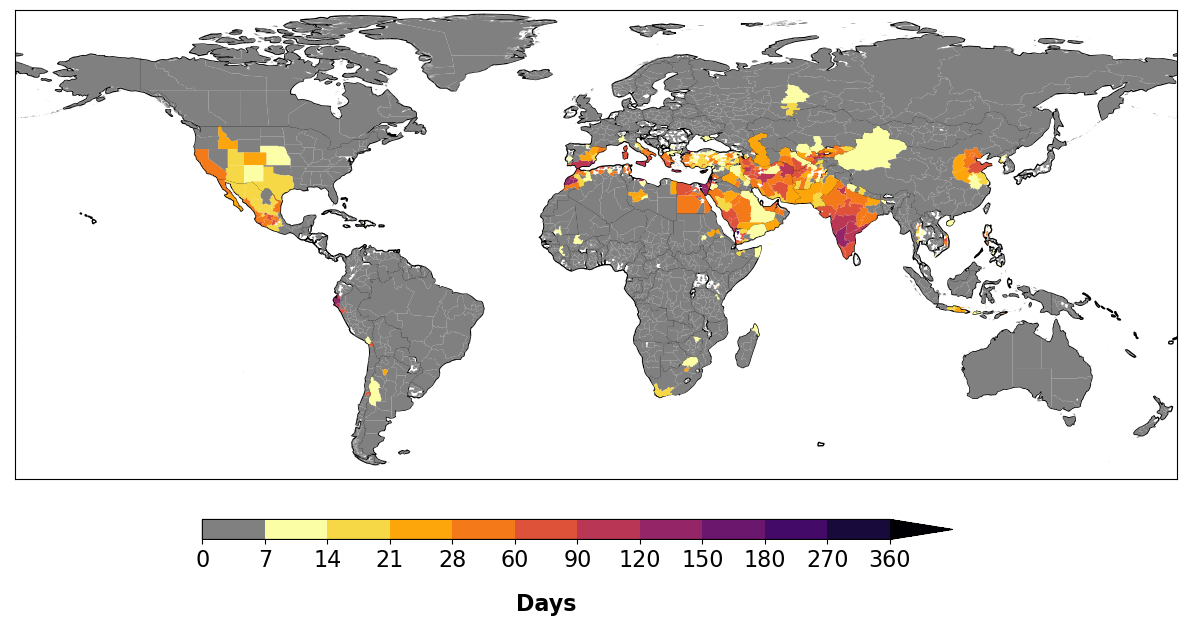

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the world boundaries from geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the geometries with the results
merged = gdf.merge(grouped, on=['NAME_0', 'NAME_1'])

# Define discrete bounds and colormap
bounds = [0, 7, 14, 21, 28, 60, 90, 120, 150, 180, 270, 360]
norm = mcolors.BoundaryNorm(bounds, plt.cm.inferno_r.N, extend='max')

# Create a list of colors from the colormap
colors = plt.cm.inferno_r(np.linspace(0, 1, len(bounds)-1))
# Change the first color to gray
colors = np.vstack([[0.5, 0.5, 0.5, 1.0], colors])  # RGB for gray is (0.5, 0.5, 0.5)
new_cmap = mcolors.LinearSegmentedColormap.from_list('gray_inferno', colors)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the difference with a gray color
# difference.plot(ax=ax, color='gray', edgecolor='none', zorder=1)

# Plot the world boundaries first
world.boundary.plot(ax=ax, linewidth=1, color='black', zorder=1)

merged.plot(column='Average_UNSATISFIED_DAYS', 
            cmap=new_cmap, 
            norm=norm,
            linewidth=0.8, 
            ax=ax, 
            edgecolor='none', 
            legend=False,
            zorder=2)  # Set legend to False

# Set map extent
ax.set_xlim([-180, 180])
ax.set_ylim([-60, 85])

# Remove latitude and longitude ticks
ax.set_xticks([])
ax.set_yticks([])

# Create a custom colorbar
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

# Define a position and size for the colorbar
cax = fig.add_axes([0.25, 0.2, 0.5, 0.02])  # [left, bottom, width, height]

cbar = fig.colorbar(sm, cax=cax, boundaries=bounds, ticks=bounds, orientation='horizontal', extend='max', extendfrac='auto')
cbar.set_label('Days', size=16, weight='bold', rotation=0, labelpad=15)
cbar.ax.tick_params(labelsize=16)

# Save the figure to the working directory
fig.savefig("average_unsatisfied_days_map.png", dpi=300, bbox_inches='tight')

plt.show()
